### http://www.chadfulton.com/topics/arma11_cpi_inflation.html
### http://fedc.wiwi.hu-berlin.de/xplore/tutorials/sfehtmlnode63.html

### The ARMA process reads:
$yt=ϕyt−1+εt+θ1εt−1,εt∼N(0,σ2)$

In [32]:
%matplotlib inline
%pylab inline
import pandas as pd
from scipy.optimize import minimize
from scipy import signal, optimize

import statsmodels.api as sm
import itertools

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# The Arma Model

In [111]:
###################################################################
###################################################################
def generateArma(pars, sz):
    gamma = pars[0]
    theta = pars[1]
        
    epsilon = np.random.standard_normal(sz)
    y = np.repeat(np.mean(epsilon), sz)
        
    for t in xrange(2,sz):
        y[t] = gamma*y[t-1] + epsilon[t] + theta*epsilon[t-1]

    return y, epsilon


###################################################################
def fitArma(pars, data):
    gamma = pars[0]
    theta = pars[1]
        
    y         = np.repeat(np.mean(data), len(data))
    errorsest = geterrors(data, pars)
    sigma2    = np.maximum(pars[-1]**2, 1e-6)
    axis      = 0
    nobs      = len(errorsest)
        
    for t in xrange(2, sz):
        y[t] = gamma * y[t-1] + data[t] + theta * data[t-1]

    llike  =  0.5 * (nobs*np.log(sigma2)
                      + np.sum((errorsest**2)/sigma2)
                      +  nobs*np.log(2*np.pi))
    return llike


###################################################################
def estimateARMA11V2(pars, data):
    llk, bestP0 = DoGridSearch(data, numpts0=20, printe=True)
    optim_kwds = dict(ftol=1e-50, full_output=True)
    args = (data)
    
    rh, cov_x, infodict, mesg, ier = optimize.leastsq(geterrors, bestP0, args=args, **optim_kwds)
    
    return rh, cov_x, infodict, mesg, ier


###################################################################
def estimateARMA11NoMeanMyWayVsTheHighwaY(pars, data):
    """Return estimation bias for each parameter.
       My implementation is the left; the package is on the right
    """ 
    
    llk, bestP0 = DoGridSearch(data, numpts0=5, printe=False)
    #update
    optim_kwds = dict(ftol=1e-10, full_output=True)
    args = (data)
    
    #rh, cov_x, infodict, mesg, ier = optimize.leastsq(geterrors, bestP0, args=args, **optim_kwds)
    res = minimize(fitArma, bestP0, args=args, method='BFGS')
    MyPars = res.x - pars
    print(' -> estimated pars my way = %s'%res.x)
    
    res2 = sm.tsa.ARMA(data, (1,1)).fit(trend='nc')
    Theirs = res2.params - pars
    
    print(' -> Bias My way    = %.3f;\n -> The proper way = %.3f'%(np.sum(np.abs(MyPars)), np.sum(np.abs(Theirs))))
    
    
###################################################################
def geterrors(data, params):
    #copied from sandbox.tsa.arima.ARIMA
    p, q = 1, 1
    ar = np.concatenate(([1], -params[:p]))
    ma = np.concatenate(([1], params[p:p+q]))

    #lfilter_zi requires same length for ar and ma
    maxlag = 1+max(p,q)
    armax = np.zeros(maxlag)
    armax[:p+1] = ar
    mamax = np.zeros(maxlag)
    mamax[:q+1] = ma

    errorsest = signal.lfilter(ar, ma, data)
    
    return errorsest


###################################################################
def loglike(data, params):
    """
    Loglikelihood for arma model
    """

    errorsest = geterrors(data, params)
    sigma2    = np.maximum(params[-1]**2, 1e-6)
    axis      = 0
    nobs      = len(errorsest)

    llike  =  -0.5 * (nobs*np.log(sigma2)
                      + np.sum(errorsest**2/sigma2)
                      +  nobs*np.log(2*np.pi))
    return llike


###################################################################
def DoGridSearch(sdata, numpts0=5, printe=False):
    GRID_TH = np.linspace(0.1, 0.9, numpts0+2)
    GRID_TH = GRID_TH[1:-1]

    GRID_OM = np.linspace(0.1, 0.9, numpts0+2)
    GRID_OM = GRID_OM[1:-1]

    PTS = [GRID_OM, GRID_TH]

    pars0Vec = np.array([list(x) for x in itertools.product(*PTS)])
    
    R = []
    for p0 in pars0Vec:
        R.append(loglike(sdata, p0))
        
    # entry of R where the log-likelihood is the maximum
    maxL = np.where(R == max(R))[0][0].astype(int)
    
    if printe is not False:
        print('optimal starting values are %s'%pars0Vec[maxL])
    
        
    return R, pars0Vec[maxL]

In [112]:
sz = 500
pars = np.array([0.2, 0.7])
sdata, eps = generateArma(pars, sz)

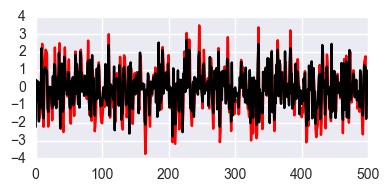

In [113]:
f, ax = plt.subplots(1,1,figsize=(4,2))
plt.plot(sdata, color='r')
plt.plot(eps, color='k')
plt.tight_layout()

# Comparing results with statsmodels:
    - I am able to retrieve the parameters of the DGP properly with statsmodels.
    - Now I must understand how they estimate these parameteres and copy-it 

In [114]:
sdata, eps = generateArma(pars, sz)
estimateARMA11NoMeanMyWayVsTheHighwaY(pars, sdata)

print(' -> True pars are  = %s'%pars)

 -> estimated pars my way = [ 0.01886011  0.85058515]
 -> Bias My way    = 0.332;
 -> The proper way = 0.133
 -> True pars are  = [ 0.2  0.7]


# Why ?
    - Lets find out why